<a href="https://colab.research.google.com/github/hanzla-khalid98/challenge-2_AN2DL_2025/blob/main/notebooks/baseline_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline CNN model



In [59]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [84]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os
from pathlib import Path


# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import datasets
import torchvision.transforms.v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec


# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.9.0+cu126
Device: cuda


## Load the dataset

In [85]:
# Load the preprocessed tensors so we can skip the heavy CSV wrangling

dataset_path = Path("/content/drive/MyDrive/data/dataset_challenge_2.pt")

if not dataset_path.exists():
    raise FileNotFoundError(
        f"dataset.pt not found"
    )

try:
    bundle = torch.load(dataset_path, map_location="cpu", weights_only=False)
except RuntimeError as err:
        raise


X_train = torch.from_numpy(bundle["X_train"]).permute(0, 3, 1, 2).float()
y_train = torch.from_numpy(bundle["y_train"]).view(-1).long()
X_val = torch.from_numpy(bundle["X_val"]).permute(0, 3, 1, 2).float()
y_val = torch.from_numpy(bundle["y_val"]).view(-1).long()
X_test = torch.from_numpy(bundle["X_test"]).permute(0, 3, 1, 2).float()

if "images_test_name" in bundle:
    images_test_name = bundle["images_test_name"]
else:
    images_test_name = None


print(f"Train tensor shape: {tuple(X_train.shape)}")
print(f"Validation tensor shape: {tuple(X_val.shape)}")
print(f"Test tensor shape: {tuple(X_test.shape)}")

Train tensor shape: (621, 4, 128, 128)
Validation tensor shape: (70, 4, 128, 128)
Test tensor shape: (477, 4, 128, 128)


In [86]:
class AugmentedDataset(torch.utils.data.Dataset):
    """
    Custom PyTorch Dataset that applies data augmentation transforms using transforms v2.

    Following the recommended approach from torchvision documentation:
    - Use ToImage() to convert PIL to tensor
    - Use ToDtype(torch.float32, scale=True) to convert to float and scale to [0, 1]

    Args:
        data (np.ndarray): Input images with shape (N, H, W, C)
        labels (np.ndarray): Labels with shape (N,)
        transform (callable, optional): Transform to apply to images
    """
    def __init__(self, data, labels, images_id=None, transform=None):
        self.data = data
        self.labels = labels
        self.images_id = images_id
        self.transform = transform

        # Base transform: convert to tensor (following v2 guidelines)
        self.to_tensor = transforms.Compose([
            transforms.ToImage(), # This will handle (H,W,C) to (C,H,W) if needed, but data is already (C,H,W)
            transforms.ToDtype(torch.float32, scale=True)
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get image and label
        image = self.data[idx] # This is already a torch.Tensor (float32, 0-1, CHW) due to previous data loading fix

        # Apply base transform: already (CHW), ToImage will pass through, ToDtype ensures float32
        image_tensor = self.to_tensor(image)

        # Apply additional transforms if provided
        if self.transform:
            image_tensor = self.transform(image_tensor)

        if self.images_id is not None:
            return image_tensor , self.images_id[idx]
        if self.labels is None:
            return image_tensor
        label = self.labels[idx]

        return image_tensor, torch.tensor(label, dtype=torch.long)


train_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    # transforms.RandomRotation(15),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    # transforms.RandomErasing(p=1.0, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0),
])

train_ds = AugmentedDataset(X_train, y_train, transform=train_augmentation)
val_ds   = AugmentedDataset(X_val, y_val, transform=None)
test_ds  = AugmentedDataset(X_test, labels=None, images_id=images_test_name, transform=None)

In [87]:
BATCH_SIZE = 64
EVAL_BATCH_SIZE = 128


def make_loader(dataset, batch_size, shuffle, drop_last):
    """Wrap tensors in a DataLoader."""
    # Setting num_workers to 0 disables multiprocessing for data loading
    # and often resolves issues with FileNotFoundError in _pin_memory_loop
    # Set pin_memory to False as it's often problematic with num_workers > 0 in Colab
    # If performance is an issue, consider experimenting with num_workers = 1 and pin_memory=True
    num_workers = 0 # os.cpu_count() or 2
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=False, # Changed to False
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=None, # Changed to None as num_workers is 0
    )

train_loader = make_loader(train_ds, BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = make_loader(val_ds, EVAL_BATCH_SIZE, shuffle=False, drop_last=False)
test_loader = make_loader(test_ds, EVAL_BATCH_SIZE, shuffle=False, drop_last=False)


# Handy metadata for configuring the model
input_size = X_train.shape[1:]
num_classes = len(torch.unique(y_train))
print(f"Input size: {input_size}, classes: {num_classes}")

Input size: torch.Size([4, 128, 128]), classes: 4


In [88]:
# Fetch a batch to capture the per-sample input shape for summaries
for xb, yb in train_loader:
    input_shape = xb.shape[1:]
    num_classes = len(np.unique(yb.cpu().numpy()))
    break

print(f"Input shape per sample: {input_shape}")

Input shape per sample: torch.Size([4, 128, 128])


## CNN class

In [89]:
class ResidualBlock(nn.Module):
    """Standard Residual Block with stackable units + Final Pooling.
    """
    def __init__(self, in_channels, filters, kernel_size=3, stack=2):
        """Initialises the ResidualBlock.

        Args:
            in_channels (int): Number of input channels.
            filters (int): Number of output filters.
            kernel_size (int, optional): Size of the convolutional kernel. Defaults to 3.
            stack (int, optional): Number of residual units to stack. Defaults to 2.
        """
        super().__init__()

        self.units = nn.ModuleList()
        current_in = in_channels

        for s in range(stack):
            layers = nn.ModuleDict()

            # Standard ResNet Unit: Conv -> BN -> ReLU -> Conv -> BN -> Add -> ReLU
            layers['conv1'] = nn.Conv2d(current_in, filters, kernel_size, padding='same', bias=False)
            layers['bn1'] = nn.BatchNorm2d(filters)
            layers['conv2'] = nn.Conv2d(filters, filters, kernel_size, padding='same', bias=False)
            layers['bn2'] = nn.BatchNorm2d(filters)

            # Skip connection projection if dimensions mismatch
            if current_in != filters:
                layers['proj'] = nn.Sequential(
                    nn.Conv2d(current_in, filters, 1, padding='same', bias=False),
                    nn.BatchNorm2d(filters)
                )

            self.units.append(layers)
            current_in = filters # After first stack, input matches filters

        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        """Defines the forward pass.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after block processing.
        """
        for unit in self.units:
            residual = x

            out = unit['conv1'](x)
            out = unit['bn1'](out)
            out = F.relu(out)

            out = unit['conv2'](out)
            out = unit['bn2'](out)

            if 'proj' in unit:
                residual = unit['proj'](residual)

            out += residual
            x = F.relu(out)

        return self.pool(x)

class ResNetModel(nn.Module):
    """Complete CNN model using multiple ResidualBlocks and Global Average Pooling.

    Suitable for classification tasks with deep architectures.
    """
    def __init__(self, input_shape, output_shape, filters=32, kernel_size=3, stack=2, blocks=3):
        """Initialises the ResNetModel.

        Args:
            input_shape (tuple): Shape of the input images (C, H, W).
            output_shape (int): Number of output classes.
            filters (int, optional): Initial number of filters for the first block. Defaults to 32.
            kernel_size (int, optional): Kernel size for convolutional layers. Defaults to 3.
            stack (int, optional): Number of residual units per block. Defaults to 2.
            blocks (int, optional): Number of `ResidualBlock` instances to stack. Defaults to 3.
        """
        super().__init__()

        self.blocks_list = nn.ModuleList()
        current_channels = input_shape[0]
        current_filters = filters

        # Stack ResidualBlocks, typically doubling filters for each.
        for b in range(blocks):
            self.blocks_list.append(
                ResidualBlock(current_channels, current_filters, kernel_size, stack)
            )
            current_channels = current_filters
            current_filters *= 2

        # Global Average Pooling, Flatten, and Dense layer for classification.
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(current_channels, output_shape)

    def forward(self, x):
        """Defines the forward pass.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output probabilities after Softmax activation.
        """
        for block in self.blocks_list:
            x = block(x)
        x = self.gap(x)
        x = self.flatten(x)
        x = self.dense(x)
        return F.softmax(x, dim=1)

## training and evaluating functions

In [90]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # permute inputs (batch, channel, height, width)
        # inputs = inputs.permute(0, 3, 1, 2) # This line is now redundant after AugmentedDataset fix

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [91]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # permute inputs (batch, channel, height, width)
            # inputs = inputs.permute(0, 3, 1, 2) # This line is now redundant after AugmentedDataset fix

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [92]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, scheduler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        scheduler.step()

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)


        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

## Hyperparameters

In [105]:
# Number of training epochs
LEARNING_RATE = 3e-4
EPOCHS = 150
PATIENCE = 20

# Regularisation
L1_LAMBDA = 1e-6            # L1 penalty
L2_LAMBDA = 1e-4            # L2 penalty

# CNN Architecture parameters for grid search (will need model definition update)
KERNEL_SIZE = 3

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Print the defined parameters
print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rare:", LEARNING_RATE)
print("L1 Penalty:", L1_LAMBDA)
print("L2 Penalty:", L2_LAMBDA)
print("Kernel Size:", KERNEL_SIZE)

Epochs: 150
Batch Size: 64
Learning Rare: 0.0003
L1 Penalty: 1e-06
L2 Penalty: 0.0001
Kernel Size: 3


In [110]:
# CNN Architecture parameters
# Number of convolutional blocks
NUM_BLOCKS = 1

FILTERS = 32

STACK =2

BLOCKS = 2

print("Num Blocks:", NUM_BLOCKS)
print("Channel Multiplier:", FILTERS)
print("Channel Multiplier:", STACK)
print("Channel Multiplier:", BLOCKS)

Num Blocks: 1
Channel Multiplier: 32
Channel Multiplier: 2
Channel Multiplier: 2


## Training

In [111]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [112]:
# Instantiate CNN model and move to computing device (CPU/GPU)


cnn_model = ResNetModel(
    input_shape,
    num_classes,
    filters=FILTERS,
    kernel_size=KERNEL_SIZE,
    stack=STACK,
    blocks=BLOCKS
    ).to(device)

# Display model architecture summary
summary(cnn_model, input_size=input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]           1,152
       BatchNorm2d-2         [-1, 32, 128, 128]              64
            Conv2d-3         [-1, 32, 128, 128]           9,216
       BatchNorm2d-4         [-1, 32, 128, 128]              64
            Conv2d-5         [-1, 32, 128, 128]             128
       BatchNorm2d-6         [-1, 32, 128, 128]              64
            Conv2d-7         [-1, 32, 128, 128]           9,216
       BatchNorm2d-8         [-1, 32, 128, 128]              64
            Conv2d-9         [-1, 32, 128, 128]           9,216
      BatchNorm2d-10         [-1, 32, 128, 128]              64
        MaxPool2d-11           [-1, 32, 64, 64]               0
    ResidualBlock-12           [-1, 32, 64, 64]               0
           Conv2d-13           [-1, 64, 64, 64]          18,432
      BatchNorm2d-14           [-1, 64,

In [113]:
# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(cnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS,       # your total epochs
    eta_min=1e-6
)

In [114]:
experiment_name = "cnn_RES_3"

writer = SummaryWriter(f"./{logs_dir}/cnn")


# %%time
# Train model and track training history
cnn_model, training_history = fit(
    model=cnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    device=device,
    l1_lambda=L1_LAMBDA,
    l2_lambda=L2_LAMBDA,
    patience=PATIENCE,
    evaluation_metric="val_f1",
    mode='max',
    restore_best_weights=True,
    writer=writer,
    verbose=1,
    experiment_name=experiment_name,
    )

# Update best model if current performance is superior
if training_history['val_f1'][-1] > best_performance:
    best_model = cnn_model
    best_performance = training_history['val_f1'][-1]

Training 150 epochs...
Epoch   1/150 | Train: Loss=1.4387, F1 Score=0.2112 | Val: Loss=1.3709, F1 Score=0.2729
Epoch   2/150 | Train: Loss=1.4295, F1 Score=0.2131 | Val: Loss=1.3660, F1 Score=0.2742
Epoch   3/150 | Train: Loss=1.4261, F1 Score=0.2343 | Val: Loss=1.3613, F1 Score=0.2603
Epoch   4/150 | Train: Loss=1.4243, F1 Score=0.2268 | Val: Loss=1.3588, F1 Score=0.2946
Epoch   5/150 | Train: Loss=1.4226, F1 Score=0.2780 | Val: Loss=1.3565, F1 Score=0.3425
Epoch   6/150 | Train: Loss=1.4202, F1 Score=0.2870 | Val: Loss=1.3549, F1 Score=0.3265
Epoch   7/150 | Train: Loss=1.4191, F1 Score=0.2886 | Val: Loss=1.3551, F1 Score=0.3821
Epoch   8/150 | Train: Loss=1.4173, F1 Score=0.3234 | Val: Loss=1.3667, F1 Score=0.2372
Epoch   9/150 | Train: Loss=1.4167, F1 Score=0.3170 | Val: Loss=1.3503, F1 Score=0.3844
Epoch  10/150 | Train: Loss=1.4149, F1 Score=0.2962 | Val: Loss=1.3522, F1 Score=0.3820
Epoch  11/150 | Train: Loss=1.4162, F1 Score=0.3078 | Val: Loss=1.3681, F1 Score=0.2286
Epoch  12

## Evaluation

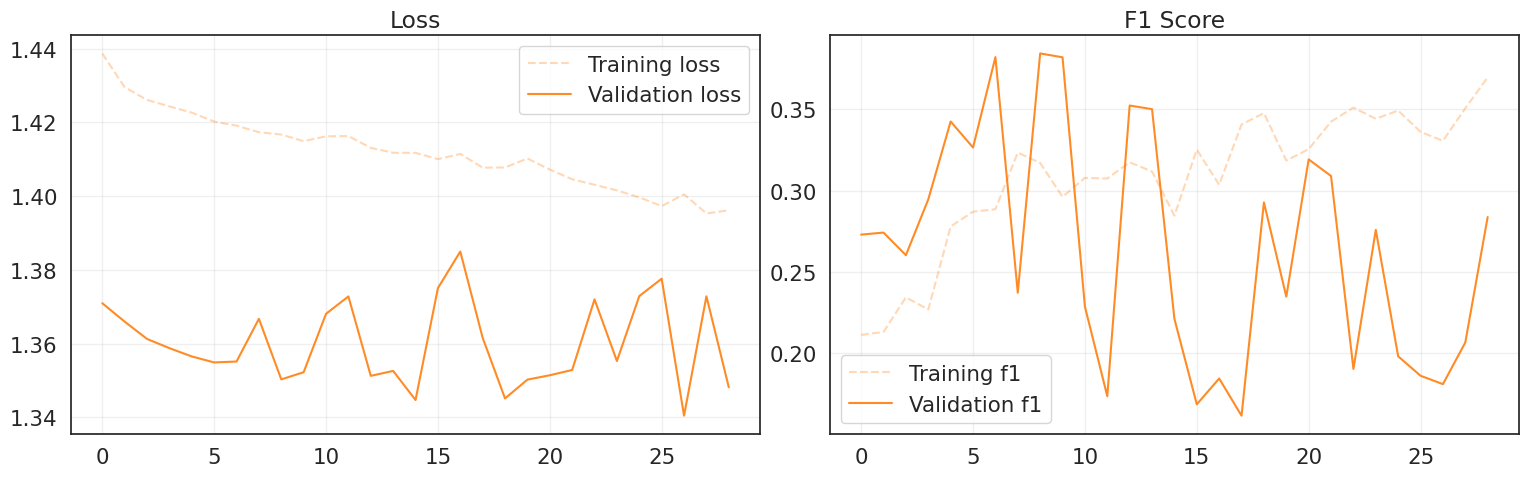

In [115]:
# @title Plot Hitory
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

Accuracy over the validation set: 0.4286
Precision over the validation set: 0.4015
Recall over the validation set: 0.4286
F1 score over the validation set: 0.3844


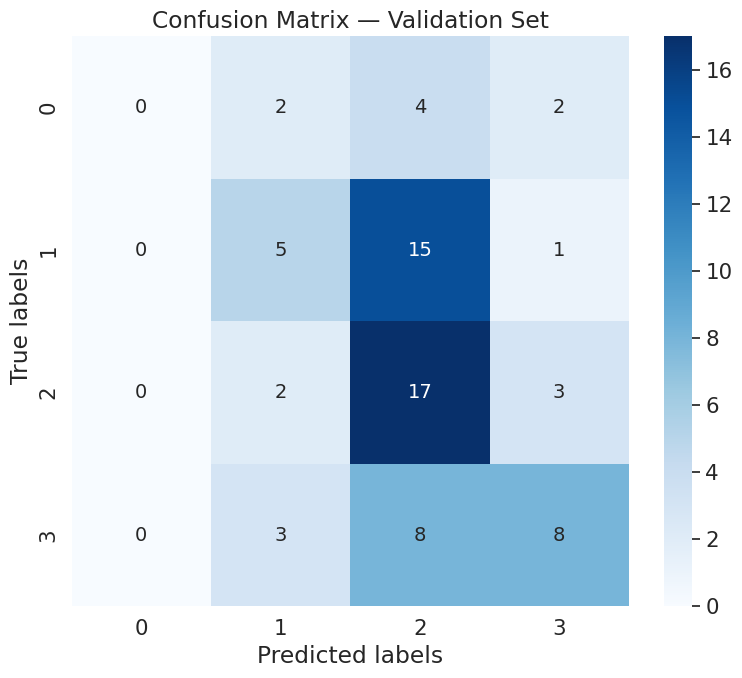

In [116]:
# @title Plot Confusion Matrix
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)
        # Permute dimensions from (batch_size, height, width, channels) to (batch_size, channels, height, width)
        # This line is now redundant and incorrect as data is already (Batch, Channels, Height, Width)
        # xb = xb.permute(0, 3, 1, 2)

        # Forward pass: get model predictions
        logits = cnn_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

## Hyperparameter Tuning

In [122]:
# ----------------------------
# Hyperparameter search space
# ----------------------------

def grid_search(
    param_grid,
    input_shape,
    num_classes,
    train_loader,
    val_loader,
    criterion,
    device,
    base_config=None,
    max_epochs=100,
    patience=15,
    weight_decay=0.0,
    verbose=1,
    save_path="models/best_resnet_grid_search.pt"
):
    """
    Performs grid search over hyperparameters for the CNN model.

    param_grid: dict of lists
    base_config: optional dictionary of CNN parameters to keep fixed
    """

    import itertools
    import copy

    # Expand hyperparameter grid
    all_configs = list(itertools.product(*param_grid.values()))
    print(f"\nTotal configurations: {len(all_configs)}\n")

    results = []
    best_score = -float("inf")
    best_params = None
    best_model_state = None

    # Training loop over all combinations
    for config in all_configs:
        hparams = dict(zip(param_grid.keys(), config))

        # Merge with fixed parameters (if provided)
        if base_config:
            full_params = {**base_config, **hparams}
        else:
            full_params = hparams

        print("\n========================================")
        print("Testing configuration:", full_params)
        print("========================================")


        # Build model using supplied parameters
        model = ResNetModel(
            input_shape=input_shape,
            output_shape=num_classes,
            filters=full_params["filters"],
            kernel_size=full_params["kernel_size"],
            stack=full_params["stack"],

        ).to(device)

        # Optimizer
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=full_params["lr"],
            weight_decay=weight_decay
        )

        # AMP scaler
        scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

        # Train model
        model, history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=max_epochs,
            criterion=criterion,
            optimizer=optimizer,
            scaler=scaler,
            scheduler=scheduler,
            device=device,
            patience=patience,
            experiment_name="grid_temp",
            verbose=0,
        )

        # Score to compare models
        val_f1 = np.max(history["val_f1"])
        print(f" → F1 Score: {val_f1:.4f}")

        # Save results
        row = full_params.copy()
        row["val_f1"] = val_f1
        results.append(row)

        # Track best model
        if val_f1 > best_score:
            best_score = val_f1
            best_params = full_params.copy()
            best_model_state = copy.deepcopy(model.state_dict())

        # Free GPU memory
        del model
        torch.cuda.empty_cache()

    # Save best model
    torch.save(best_model_state, save_path)

    print("\n========================")
    print("Best hyperparameters:")
    print(best_params)
    print("Best F1:", best_score)
    print("========================")

    # Return results as DataFrame
    return pd.DataFrame(results), best_params, best_score


In [ ]:
param_grid = {
    "filters": [16, 32, 64],
    "kernel_size": [3, 5],
    "stack": [1, 2, 3],
    "blocks": [1, 2, 3],
    "learning_rate": [1e-3, 3e-4, 1e-4],
}


# Fixed parameters (architecture options you don't want to grid-search)
base_config = {
    "lr": LEARNING_RATE,
    "weight_decay": L2_LAMBDA
}

df_results, best_params, best_score = grid_search(
    param_grid=param_grid,
    input_shape=input_shape,
    num_classes=num_classes,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    device=device,
    base_config=base_config,
    weight_decay=L2_LAMBDA,
    max_epochs=50,
    patience=15,
    save_path="models/best_resnet_grid_search.pt"
)



Total configurations: 162


Testing configuration: {'lr': 0.0003, 'weight_decay': 0.0001, 'filters': 16, 'kernel_size': 3, 'stack': 1, 'blocks': 1, 'learning_rate': 0.001}
Training 50 epochs...


In [ ]:
df_results

## Inference

In [117]:
cnn_model = best_model

In [118]:
list_preds = []
list_idx = []
with torch.no_grad():  # Disable gradient computation for inference
    for batch_idx, xb in enumerate(test_loader):
        xb = xb.to(device)

        # permute inputs (This line is incorrect as the data is already in the correct format (Batch, Channels, Height, Width))
        # xb = xb.permute(0, 3, 1, 2)

        # Forward pass: get model predictions
        logits = cnn_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        list_preds.append(preds)

        # Calculate the actual sample indices for this batch
        start_index = batch_idx * EVAL_BATCH_SIZE
        current_batch_size = len(preds) # Use len(preds) to handle the last batch possibly being smaller
        batch_sample_indices = np.arange(start_index, start_index + current_batch_size)
        list_idx.append(batch_sample_indices)

# Combine all batches into single arrays
list_preds = np.concatenate(list_preds)
list_idx = np.concatenate(list_idx)

# Create a DataFrame for the predictions
df_preds = pd.DataFrame({"sample_index": list_idx, "label": list_preds})

In [ ]:
all_preds = []
all_image_ids = []

with torch.no_grad():
    for xb, image_ids in test_loader:
        xb = xb.to(device)

        logits = cnn_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        all_preds.extend(preds)
        # Fix: Remove .numpy() as image_ids is already a list/tuple of strings
        all_image_ids.extend(image_ids)

# Aggregate per image
df_tiles = pd.DataFrame({
    "image_id": all_image_ids,
    "pred": all_preds
})

final_preds = {}

for img_id, group in df_tiles.groupby("image_id"):
    final_preds[img_id] = group["pred"].mode()[0]   # majority vote

# Make submission df
df_preds = pd.DataFrame({
    "sample_index": list(final_preds.keys()),
    "label": list(final_preds.values())
}).sort_values("sample_index")

print(df_preds)

     sample_index  label
0    img_0000.png      1
1    img_0001.png      2
2    img_0002.png      1
3    img_0003.png      3
4    img_0004.png      3
..            ...    ...
472  img_0472.png      1
473  img_0473.png      1
474  img_0474.png      2
475  img_0475.png      1
476  img_0476.png      1

[477 rows x 2 columns]


In [119]:
# mapping labels
mapping = {0: 'Triple negative',
             1: 'Luminal A',
             2: 'Luminal B',
             3: 'HER2(+)'}

df_preds['label'] = df_preds['label'].map(mapping)
df_preds["sample_index"] = df_preds["sample_index"].apply(lambda x: f"img_{int(x):04d}.png")

In [120]:
df_preds.head()

,sample_index,label
0,img_0000.png,Luminal B
1,img_0001.png,HER2(+)
2,img_0002.png,Luminal B
3,img_0003.png,Luminal A
4,img_0004.png,Luminal B


In [121]:
df_preds.to_csv('predictions.csv', index=False, header=True)